# ML Scripts

So far, we've done everything inside the Jupyter notebooks but we're going to now move our code into individual python scripts. We will lay out the code that needs to be inside each script but checkout the `API` lesson to see how it all comes together.

<div align="left">
<a href="https://github.com/madewithml/lessons/blob/master/notebooks/03_APIs/02_ML_Scripts/02_PT_ML_Scripts.ipynb" role="button"><img class="notebook-badge-image" src="https://img.shields.io/static/v1?label=&amp;message=View%20On%20GitHub&amp;color=586069&amp;logo=github&amp;labelColor=2f363d"></a>&nbsp;
<a href="https://colab.research.google.com/github/madewithml/lessons/blob/master/notebooks/03_APIs/02_ML_Scripts/02_PT_ML_Scripts.ipynb"><img class="notebook-badge-image" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
</div>

# data.py

## Load data

In [0]:
import numpy as np
import pandas as pd
import random
import urllib

In [0]:
SEED = 1234
DATA_FILE = 'news.csv'
INPUT_FEATURE = 'title'
OUTPUT_FEATURE = 'category'

In [0]:
# Set seed for reproducibility
np.random.seed(SEED)
random.seed(SEED)

In [0]:
# Load data from GitHub to notebook's local drive
url = "https://raw.githubusercontent.com/madewithml/lessons/master/data/news.csv"
response = urllib.request.urlopen(url)
html = response.read()
with open(DATA_FILE, 'wb') as fp:
    fp.write(html)

In [0]:
# Load data
df = pd.read_csv(DATA_FILE, header=0)
X = df[INPUT_FEATURE].values
y = df[OUTPUT_FEATURE].values
df.head(5)

,title,category
0,Wall St. Bears Claw Back Into the Black (Reuters),Business
1,Carlyle Looks Toward Commercial Aerospace (Reu...,Business
2,Oil and Economy Cloud Stocks' Outlook (Reuters),Business
3,Iraq Halts Oil Exports from Main Southern Pipe...,Business
4,"Oil prices soar to all-time record, posing new...",Business


## Preprocessing

In [0]:
import re

In [0]:
LOWER = True
FILTERS = r"[!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~]"

In [0]:
def preprocess_texts(texts, lower, filters):
    preprocessed_texts = []
    for text in texts: 
        if lower:
            text = ' '.join(word.lower() for word in text.split(" "))
        text = re.sub(r"([.,!?])", r" \1 ", text)
        text = re.sub(filters, r"", text)
        text = re.sub(' +', ' ', text) # remove multiple spaces
        text = text.strip()
        preprocessed_texts.append(text)
    return preprocessed_texts

In [0]:
original_text = X[0]
X = np.array(preprocess_texts(X, lower=LOWER, filters=FILTERS))
print (f"{original_text} → {X[0]}")

Wall St. Bears Claw Back Into the Black (Reuters) → wall st bears claw back into the black reuters


## Split data

In [0]:
import collections
from sklearn.model_selection import train_test_split

In [0]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15
SHUFFLE = True

In [0]:
def train_val_test_split(X, y, val_size, test_size, shuffle):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, shuffle=shuffle)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_size, stratify=y_train, shuffle=shuffle)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [0]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, val_size=VAL_SIZE, test_size=TEST_SIZE, shuffle=SHUFFLE)
class_counts = dict(collections.Counter(y))
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"{X_train[0]} → {y_train[0]}")
print (f"Classes: {class_counts}")

X_train: (86700,), y_train: (86700,)
X_val: (15300,), y_val: (15300,)
X_test: (18000,), y_test: (18000,)
pga overhauls system for ryder cup points → Sports
Classes: {'Business': 30000, 'Sci/Tech': 30000, 'Sports': 30000, 'World': 30000}


# tokenizers.py

## Tokenizer

In [0]:
import json
import re

In [0]:
SEPARATOR = ' ' # word level

In [0]:
class Tokenizer(object):
    def __init__(self, separator, pad_token='<PAD>', oov_token='<UNK>',
                 token_to_index={'<PAD>': 0, '<UNK>': 1}):
        self.separator = separator
        self.oov_token = oov_token
        self.token_to_index = token_to_index
        self.index_to_token = {v: k for k, v in self.token_to_index.items()}

    def __len__(self):
        return len(self.token_to_index)
    
    def __str__(self):
        return f"<Tokenizer(num_tokens={len(self)})>"

    def fit_on_texts(self, texts):
        for text in texts:
            for token in text.split(self.separator):
                if token not in self.token_to_index:
                    index = len(self)
                    self.token_to_index[token] = index
                    self.index_to_token[index] = token
        return self

    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            sequence = []
            for token in text.split(self.separator):
                sequence.append(self.token_to_index.get(
                    token, self.token_to_index[self.oov_token]))
            sequences.append(sequence)
        return sequences
            
    def sequences_to_texts(self, sequences):
        texts = []
        for sequence in sequences:
            text = []
            for index in sequence:
                text.append(self.index_to_token.get(index, self.oov_token))
            texts.append(self.separator.join([token for token in text]))
        return texts

    def save(self, fp):
        with open(fp, 'w') as fp:
            contents = {
                'separator': self.separator,
                'oov_token': self.oov_token,
                'token_to_index': self.token_to_index
            }
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, 'r') as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [0]:
# Input vectorizer
X_tokenizer = Tokenizer(separator=SEPARATOR)
X_tokenizer.fit_on_texts(texts=X_train)
vocab_size = len(X_tokenizer)
print (X_tokenizer)

<Tokenizer(num_tokens=35635)>


In [0]:
# Convert text to sequence of tokens
original_text = X_train[0]
X_train = np.array(X_tokenizer.texts_to_sequences(X_train))
X_val = np.array(X_tokenizer.texts_to_sequences(X_val))
X_test = np.array(X_tokenizer.texts_to_sequences(X_test))
preprocessed_text = X_tokenizer.sequences_to_texts([X_train[0]])
print (f"{original_text} \n\t→ {preprocessed_text} \n\t→ {X_train[0]}")

pga overhauls system for ryder cup points 
	→ ['pga overhauls system for ryder cup points'] 
	→ [2, 3, 4, 5, 6, 7, 8]


In [0]:
# Save tokenizer
X_tokenizer.save(fp='X_tokenizer.json')

In [0]:
# Load tokenizer
X_tokenizer = Tokenizer.load(fp='X_tokenizer.json')
print (X_tokenizer)

<Tokenizer(num_tokens=35635)>


## Label Encoder

In [0]:
class LabelEncoder(object):
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y_train):
        for i, class_ in enumerate(np.unique(y_train)):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self
    
    def transform(self, y):
        return np.array([self.class_to_index[class_] for class_ in y])

    def decode(self, index):
        return self.index_to_class.get(index, None)
    
    def save(self, fp):
        with open(fp, 'w') as fp:
            contents = {
                'class_to_index': self.class_to_index
            }
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, 'r') as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [0]:
# Output vectorizer
y_tokenizer = LabelEncoder()

In [0]:
# Fit on train data
y_tokenizer = y_tokenizer.fit(y_train)
print (y_tokenizer)
classes = y_tokenizer.classes
print (f"classes: {classes}")

<LabelEncoder(num_classes=4)>
classes: ['Business', 'Sci/Tech', 'Sports', 'World']


In [0]:
# Convert labels to tokens
class_ = y_train[0]
y_train = y_tokenizer.transform(y_train)
y_val = y_tokenizer.transform(y_val)
y_test = y_tokenizer.transform(y_test)
print (f"{class_} → {y_train[0]}")

Sports → 2


In [0]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"class counts: {counts},\nclass weights: {class_weights}")

class counts: [21675 21675 21675 21675],
class weights: {0: 4.61361014994233e-05, 1: 4.61361014994233e-05, 2: 4.61361014994233e-05, 3: 4.61361014994233e-05}


In [0]:
# Save label encoder
y_tokenizer.save(fp='y_tokenizer.json')

In [0]:
# Load label encoder
y_tokenizer = LabelEncoder.load(fp='y_tokenizer.json')
print (y_tokenizer)

<LabelEncoder(num_classes=4)>


# datasets.py

In [0]:
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [0]:
BATCH_SIZE = 128
FILTER_SIZES = [2, 3, 4]

In [0]:
# Set seed for reproducibility
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED) # multi-GPU.
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [0]:
USE_CUDA = True
DEVICE = torch.device('cuda' if (torch.cuda.is_available() and USE_CUDA) else 'cpu')
print (DEVICE)

cuda


## Pad

In [0]:
def pad_sequences(X, max_seq_len):
    sequences = np.zeros((len(X), max_seq_len))
    for i, sequence in enumerate(X):
        sequences[i][:len(sequence)] = sequence
    return sequences 

In [0]:
# Pad sequences
inputs = [[1,2,3], [1,2,3,4], [1,2]]
max_seq_len = max(len(x) for x in inputs)
padded_inputs = pad_sequences(X=inputs, max_seq_len=max_seq_len)
print (padded_inputs.shape)
print (padded_inputs)

(3, 4)
[[1. 2. 3. 0.]
 [1. 2. 3. 4.]
 [1. 2. 0. 0.]]


## Dataset

In [0]:
class TextDataset(Dataset):
    def __init__(self, X, y, batch_size, max_filter_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.max_filter_size = max_filter_size

    def __len__(self):
        return len(self.y)

    def __str__(self):
        return f"<Dataset(N={len(self)}, batch_size={self.batch_size}, num_batches={self.get_num_batches()})>"

    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        return X, y

    def get_num_batches(self):
        return math.ceil(len(self)/self.batch_size)

    def collate_fn(self, batch):
        """Processing on a batch."""
        # Get inputs
        X = np.array(batch)[:, 0]
        y = np.array(batch)[:, 1]

        # Pad inputs
        max_seq_len = max(self.max_filter_size, max([len(x) for x in X]))
        X = pad_sequences(X=X, max_seq_len=max_seq_len)

        return X, y

    def generate_batches(self, shuffle=False, drop_last=False):
        dataloader = DataLoader(dataset=self, batch_size=self.batch_size, 
                                collate_fn=self.collate_fn, shuffle=shuffle, 
                                drop_last=drop_last, pin_memory=True)
        for (X, y) in dataloader:
            X = torch.LongTensor(X.astype(np.int32))
            y = torch.LongTensor(y.astype(np.int32))
            yield X, y

In [0]:
# Create datasets
train_set = TextDataset(X=X_train, y=y_train, batch_size=BATCH_SIZE, max_filter_size=max(FILTER_SIZES))
val_set = TextDataset(X=X_val, y=y_val, batch_size=BATCH_SIZE, max_filter_size=max(FILTER_SIZES))
test_set = TextDataset(X=X_test, y=y_test, batch_size=BATCH_SIZE, max_filter_size=max(FILTER_SIZES))
print (train_set)
print (train_set[0])

<Dataset(N=86700, batch_size=128, num_batches=678)>
([2, 3, 4, 5, 6, 7, 8], 2)


In [0]:
# Generate batch
batch_X, batch_y = next(iter(test_set.generate_batches()))
print (batch_X.shape)
print (batch_y.shape)

torch.Size([128, 13])
torch.Size([128])


# utils.py

## Embeddings

In [0]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

In [0]:
EMBEDDING_DIM = 100

In [0]:
def load_glove_embeddings(embeddings_file):
    """Load embeddings from a file."""
    embeddings = {}
    with open(embeddings_file, "r") as fp:
        for index, line in enumerate(fp):
            values = line.split()
            word = values[0]
            embedding = np.asarray(values[1:], dtype='float32')
            embeddings[word] = embedding
    return embeddings

In [0]:
def make_embeddings_matrix(embeddings, token_to_index, embedding_dim):
    """Create embeddings matrix to use in Embedding layer."""
    embedding_matrix = np.zeros((len(token_to_index), embedding_dim))
    for word, i in token_to_index.items():
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [0]:
# Unzip the file (may take ~3-5 minutes)
resp = urlopen('http://nlp.stanford.edu/data/glove.6B.zip')
zipfile = ZipFile(BytesIO(resp.read()))
zipfile.namelist()

['glove.6B.50d.txt',
 'glove.6B.100d.txt',
 'glove.6B.200d.txt',
 'glove.6B.300d.txt']

In [0]:
# Write embeddings to file
embeddings_file = 'glove.6B.{0}d.txt'.format(EMBEDDING_DIM)
zipfile.extract(embeddings_file)
!ls

glove.6B.100d.txt  news.csv  sample_data  X_tokenizer.json  y_tokenizer.json


In [0]:
# Create embeddings
embeddings_file = 'glove.6B.{0}d.txt'.format(EMBEDDING_DIM)
glove_embeddings = load_glove_embeddings(embeddings_file=embeddings_file)
embedding_matrix = make_embeddings_matrix(
    embeddings=glove_embeddings, token_to_index=X_tokenizer.token_to_index, 
    embedding_dim=EMBEDDING_DIM)
print (embedding_matrix.shape)

(35635, 100)


# model.py

## Model

In [0]:
import torch.nn.functional as F

In [0]:
NUM_FILTERS = 50
HIDDEN_DIM = 128
DROPOUT_P = 0.1

In [0]:
class TextCNN(nn.Module):
    def __init__(self, embedding_dim, vocab_size, num_filters, filter_sizes, 
                 hidden_dim, dropout_p, num_classes, pretrained_embeddings=None, 
                 freeze_embeddings=False, padding_idx=0):
        super(TextCNN, self).__init__()

        # Initialize embeddings
        if pretrained_embeddings is None:
            self.embeddings = nn.Embedding(
                embedding_dim=embedding_dim, num_embeddings=vocab_size, 
                padding_idx=padding_idx)
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.embeddings = nn.Embedding(
                embedding_dim=embedding_dim, num_embeddings=vocab_size, 
                padding_idx=padding_idx, _weight=pretrained_embeddings)
        
        # Freeze embeddings or not
        if freeze_embeddings:
            self.embeddings.weight.requires_grad = False
        
        # Conv weights
        self.filter_sizes = filter_sizes
        self.conv = nn.ModuleList(
            [nn.Conv1d(in_channels=embedding_dim, 
                       out_channels=num_filters, 
                       kernel_size=f) for f in filter_sizes])
     
        # FC weights
        self.dropout = nn.Dropout(dropout_p)
        self.fc1 = nn.Linear(num_filters*len(filter_sizes), hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x_in, channel_first=False):
        
        # Embed
        x_in = self.embeddings(x_in)
        if not channel_first:
            x_in = x_in.transpose(1, 2) # (N, channels, sequence length)
            
        # Conv + pool
        z = []
        conv_outputs = [] # for interpretability
        max_seq_len = x_in.shape[2]
        for i, f in enumerate(self.filter_sizes):
            # `SAME` padding
            padding_left = int((self.conv[i].stride[0]*(max_seq_len-1) - max_seq_len + self.filter_sizes[i])/2)
            padding_right = int(math.ceil((self.conv[i].stride[0]*(max_seq_len-1) - max_seq_len + self.filter_sizes[i])/2))

            # Conv + pool
            _z = self.conv[i](F.pad(x_in, (padding_left, padding_right)))
            conv_outputs.append(_z)
            _z = F.max_pool1d(_z, _z.size(2)).squeeze(2)
            z.append(_z)
        
        # Concat conv outputs
        z = torch.cat(z, 1)

        # FC layers
        z = self.fc1(z)
        z = self.dropout(z)
        logits = self.fc2(z)

        return conv_outputs, logits

In [0]:
# Initialize model
model = TextCNN(embedding_dim=EMBEDDING_DIM,
                vocab_size=vocab_size,
                num_filters=NUM_FILTERS,
                filter_sizes=FILTER_SIZES,
                hidden_dim=HIDDEN_DIM,
                dropout_p=DROPOUT_P,
                num_classes=len(classes),
                pretrained_embeddings=embedding_matrix,
                freeze_embeddings=False).to(DEVICE)
print (model.named_parameters)

<bound method Module.named_parameters of TextCNN(
  (embeddings): Embedding(35635, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 50, kernel_size=(2,), stride=(1,))
    (1): Conv1d(100, 50, kernel_size=(3,), stride=(1,))
    (2): Conv1d(100, 50, kernel_size=(4,), stride=(1,))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=150, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)>


# train.py

## Training

In [0]:
from pathlib import Path
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
LEARNING_RATE = 1e-4
PATIENCE = 3
NUM_EPOCHS = 100

In [0]:
def train_step(model, device, dataset, optimizer):
    """Train step."""
    # Set model to train mode
    model.train()
    train_loss = 0.
    correct = 0

    # Iterate over train batches
    for i, (X, y) in enumerate(dataset.generate_batches()):

        # Set device
        X, y = X.to(device), y.to(device)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        _, logits = model(X)

        # Define loss
        loss = F.cross_entropy(logits, y)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Metrics
        y_pred = logits.max(dim=1)[1] 
        correct += torch.eq(y_pred, y).sum().item()
        train_loss += (loss.item() - train_loss) / (i + 1)

    train_acc = 100. * correct / len(dataset)
    return train_loss, train_acc

In [0]:
def test_step(model, device, dataset):
    """Validation or test step."""
    # Set model to eval mode
    model.eval()
    loss = 0.
    correct = 0
    y_preds = []
    y_targets = []

    # Iterate over val batches
    with torch.no_grad():
        for i, (X, y) in enumerate(dataset.generate_batches()):

            # Set device
            X, y = X.to(device), y.to(device)

            # Forward pass
            _, logits = model(X)
            
            # Metrics
            loss += F.cross_entropy(logits, y, reduction='sum').item()
            y_pred = logits.max(dim=1)[1] 
            correct += torch.eq(y_pred, y).sum().item()

            # Outputs
            y_preds.extend(y_pred.cpu().numpy())
            y_targets.extend(y.cpu().numpy())

    loss /= len(dataset)
    accuracy = 100. * correct / len(dataset)
    return y_preds, y_targets, loss, accuracy

In [0]:
def train(model, optimizer, scheduler, 
          train_set, val_set, test_set, writer):
    # Epochs
    best_val_loss = np.inf
    for epoch in range(NUM_EPOCHS):
        # Steps
        train_loss, train_acc = train_step(model, DEVICE, train_set, optimizer)
        _, _, val_loss, val_acc = test_step(model, DEVICE, val_set)

        # Metrics
        print (f"Epoch: {epoch} | train_loss: {train_loss:.2f}, train_acc: {train_acc:.1f}, val_loss: {val_loss:.2f}, val_acc: {val_acc:.1f}")
        writer.add_scalar(tag='training loss', scalar_value=train_loss, global_step=epoch)
        writer.add_scalar(tag='training accuracy', scalar_value=train_acc, global_step=epoch)
        writer.add_scalar(tag='validation loss', scalar_value=val_loss, global_step=epoch)
        writer.add_scalar(tag='validation accuracy', scalar_value=val_acc, global_step=epoch)

        # Adjust learning rate
        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = PATIENCE # reset patience
            torch.save(model.state_dict(), MODEL_PATH)
        else:
            patience -= 1
        if not patience: # 0
            print ("Stopping early!")
            break

In [0]:
# Optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE) 
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [0]:
# Path to save model
MODEL_NAME = 'TextCNN'
MODEL_PATH = Path(f'models/{MODEL_NAME}.h5')
Path(MODEL_PATH.parent).mkdir(parents=True, exist_ok=True)

In [0]:
# TensorBoard writer
log_dir = f'tensorboard/{MODEL_NAME}'
!rm -rf {log_dir} # remove if it already exists
writer = SummaryWriter(log_dir=log_dir)

In [0]:
# Training
train(model, optimizer, scheduler, 
      train_set, val_set, test_set, writer)

Epoch: 0 | train_loss: 0.68, train_acc: 78.2, val_loss: 0.49, val_acc: 82.7
Epoch: 1 | train_loss: 0.44, train_acc: 84.6, val_loss: 0.44, val_acc: 84.6
Epoch: 2 | train_loss: 0.40, train_acc: 86.3, val_loss: 0.42, val_acc: 85.5
Epoch: 3 | train_loss: 0.36, train_acc: 87.4, val_loss: 0.40, val_acc: 86.1
Epoch: 4 | train_loss: 0.34, train_acc: 88.4, val_loss: 0.39, val_acc: 86.4
Epoch: 5 | train_loss: 0.31, train_acc: 89.2, val_loss: 0.39, val_acc: 86.6
Epoch: 6 | train_loss: 0.29, train_acc: 90.0, val_loss: 0.38, val_acc: 86.7
Epoch: 7 | train_loss: 0.27, train_acc: 90.8, val_loss: 0.38, val_acc: 86.8
Epoch: 8 | train_loss: 0.25, train_acc: 91.6, val_loss: 0.38, val_acc: 86.9
Epoch: 9 | train_loss: 0.23, train_acc: 92.3, val_loss: 0.38, val_acc: 86.9
Epoch: 10 | train_loss: 0.21, train_acc: 93.1, val_loss: 0.39, val_acc: 86.8
Stopping early!


In [0]:
%tensorboard --logdir {log_dir}

Reusing TensorBoard on port 6006 (pid 228), started 0:13:36 ago. (Use '!kill 228' to kill it.)

## Evaluation

In [0]:
import io
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

In [0]:
def plot_confusion_matrix(y_pred, y_target, classes, cmap=plt.cm.Blues):
    """Plot a confusion matrix using ground truth and predictions."""
    # Confusion matrix
    cm = confusion_matrix(y_target, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #  Figure
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    # Axis
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    ax.set_xticklabels([''] + classes)
    ax.set_yticklabels([''] + classes)
    ax.xaxis.set_label_position('bottom') 
    ax.xaxis.tick_bottom()

    # Values
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]:d} ({cm_norm[i, j]*100:.1f}%)",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Display
    plt.show()

In [0]:
def get_performance(y_pred, y_target, classes):
    """Per-class performance metrics. """
    performance = {'overall': {}, 'class': {}}
    metrics = precision_recall_fscore_support(y_target, y_pred)

    # Overall performance
    performance['overall']['precision'] = np.mean(metrics[0])
    performance['overall']['recall'] = np.mean(metrics[1])
    performance['overall']['f1'] = np.mean(metrics[2])
    performance['overall']['num_samples'] = np.float64(np.sum(metrics[3]))

    # Per-class performance
    for i in range(len(classes)):
        performance['class'][classes[i]] = {
            "precision": metrics[0][i],
            "recall": metrics[1][i],
            "f1": metrics[2][i],
            "num_samples": np.float64(metrics[3][i])
        }

    return performance

In [0]:
# Test
y_preds, y_targets, test_loss, test_acc = test_step(model, DEVICE, test_set)
print (f"test_loss: {test_loss:.2f}, test_acc: {test_acc:.1f}")

test_loss: 0.56, test_acc: 85.8


In [0]:
# Class performance
performance = get_performance(y_preds, y_targets, classes)
print (json.dumps(performance, indent=4))

{
    "overall": {
        "precision": 0.8588907674416577,
        "recall": 0.8583333333333333,
        "f1": 0.8584737440288595,
        "num_samples": 18000.0
    },
    "class": {
        "Business": {
            "precision": 0.8334845735027223,
            "recall": 0.8164444444444444,
            "f1": 0.8248765154916928,
            "num_samples": 4500.0
        },
        "Sci/Tech": {
            "precision": 0.8220540540540541,
            "recall": 0.8448888888888889,
            "f1": 0.8333150684931507,
            "num_samples": 4500.0
        },
        "Sports": {
            "precision": 0.9189374856881154,
            "recall": 0.8917777777777778,
            "f1": 0.9051539415811436,
            "num_samples": 4500.0
        },
        "World": {
            "precision": 0.8610869565217392,
            "recall": 0.8802222222222222,
            "f1": 0.8705494505494505,
            "num_samples": 4500.0
        }
    }
}


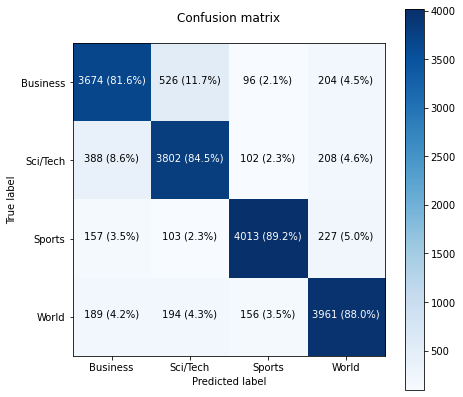

              precision    recall  f1-score   support

           0       0.83      0.82      0.82      4500
           1       0.82      0.84      0.83      4500
           2       0.92      0.89      0.91      4500
           3       0.86      0.88      0.87      4500

    accuracy                           0.86     18000
   macro avg       0.86      0.86      0.86     18000
weighted avg       0.86      0.86      0.86     18000



In [0]:
# Confusion matrix
plt.rcParams["figure.figsize"] = (7,7)
plot_confusion_matrix(y_preds, y_targets, classes)
print (classification_report(y_targets, y_preds))

# inference.py

## Load model

In [0]:
# Load model
model = TextCNN(embedding_dim=EMBEDDING_DIM,
                vocab_size=vocab_size,
                num_filters=NUM_FILTERS,
                filter_sizes=FILTER_SIZES,
                hidden_dim=HIDDEN_DIM,
                dropout_p=DROPOUT_P,
                num_classes=len(classes),
                pretrained_embeddings=embedding_matrix,
                freeze_embeddings=False).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

TextCNN(
  (embeddings): Embedding(35635, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 50, kernel_size=(2,), stride=(1,))
    (1): Conv1d(100, 50, kernel_size=(3,), stride=(1,))
    (2): Conv1d(100, 50, kernel_size=(4,), stride=(1,))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=150, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

## Inference

In [0]:
import collections

In [0]:
def get_probability_distribution(y_prob, classes):
    results = {}
    for i, class_ in enumerate(classes):
        results[class_] = np.float64(y_prob[i])
    sorted_results = {k: v for k, v in sorted(
        results.items(), key=lambda item: item[1], reverse=True)}
    return sorted_results

In [0]:
def get_top_n_grams(tokens, conv_outputs, filter_sizes):
    # Process conv outputs for each unique filter size
    n_grams = {}
    for i, filter_size in enumerate(filter_sizes):
        
        # Identify most important n-gram (excluding last token)
        popular_indices = collections.Counter([np.argmax(conv_output) \
             for conv_output in conv_outputs[filter_size]])
        
        # Get corresponding text
        start = popular_indices.most_common(1)[-1][0]
        n_gram = " ".join([token for token in tokens[start:start+filter_size]])
        n_grams[filter_size] = n_gram

    return n_grams

In [0]:
# Inputs
texts = ["The Wimbledon tennis tournament starts next week!",
         "The President signed in the new law."]
texts = preprocess_texts(texts, lower=LOWER, filters=FILTERS)
X_infer = np.array(X_tokenizer.texts_to_sequences(texts))
print (f"{texts[0]} \n\t→ {X_tokenizer.sequences_to_texts(X_infer)[0]} \n\t→ {X_infer[0]}")
y_filler = np.array([0]*len(texts))

the wimbledon tennis tournament starts next week 
	→ the wimbledon tennis tournament starts next week 
	→ [   39 20635   588   622   785   551   576]


In [0]:
# Dataset
infer_set = TextDataset(X=X_infer, y=y_filler, batch_size=BATCH_SIZE, 
                        max_filter_size=max(FILTER_SIZES))

In [0]:
# Iterate over infer batches
conv_outputs = collections.defaultdict(list)
y_probs = []
with torch.no_grad():
    for i, (X, y) in enumerate(infer_set.generate_batches()):
        
        # Set device
        X, y = X.to(DEVICE), y.to(DEVICE)

        # Forward pass
        conv_outputs_, logits = model(X)
        y_prob = F.softmax(logits, dim=1)

        # Save probabilities
        y_probs.extend(y_prob.cpu().numpy())
        for i, filter_size in enumerate(FILTER_SIZES):
            conv_outputs[filter_size].extend(conv_outputs_[i].cpu().numpy())

In [0]:
# Results
results = []
for index in range(len(X_infer)):
    results.append({
        'raw_input': texts[index],
        'preprocessed_input': X_tokenizer.sequences_to_texts([X_infer[index]])[0],
        'probabilities': get_probability_distribution(y_prob[index], y_tokenizer.classes),
        'top_n_grams': get_top_n_grams(
            tokens=preprocessed_input.split(' '), 
            conv_outputs={k:v[index] for k,v in conv_outputs.items()}, 
            filter_sizes=FILTER_SIZES)})
print (json.dumps(results, indent=4))

[
    {
        "raw_input": "the wimbledon tennis tournament starts next week",
        "preprocessed_input": "the wimbledon tennis tournament starts next week",
        "probabilities": {
            "Sports": 0.9998615980148315,
            "World": 0.0001376205327687785,
            "Business": 7.324182433876558e-07,
            "Sci/Tech": 7.507998844857866e-08
        },
        "top_n_grams": {
            "2": "tournament starts",
            "3": "the wimbledon tennis",
            "4": "tennis tournament starts next"
        }
    },
    {
        "raw_input": "the president signed in the new law",
        "preprocessed_input": "the president signed in the new law",
        "probabilities": {
            "World": 0.6943650245666504,
            "Sports": 0.14958152174949646,
            "Business": 0.1257830113172531,
            "Sci/Tech": 0.03027038462460041
        },
        "top_n_grams": {
            "2": "law",
            "3": "the president signed",
            "4"

Use inferences to collect information how the model performs on your real world data and use it to improve it over time. 
- Use a probability threshold for the top class (ex. If the predicted class is less than 75%, send the inference for review).
- Combine the above with Use probability thresholds for each class (ex. if the predicted class is `Sports` at 85% but that class's precision/recall is low, then send it for review but maybe you don't do this when the predicted class is `Sports` but above 90%.
- If the preprocessed sentence has <UNK> tokens, send the inference for further review.
- When latency is not an issue, use the n-grams to validate the prediction.

Check out the `API` lesson to see how all of this comes together to create an ML service.

---
Share and discover ML projects at <a href="https://madewithml.com/">Made With ML</a>.

<div align="left">
<a class="ai-header-badge" target="_blank" href="https://github.com/madewithml/lessons"><img src="https://img.shields.io/github/stars/madewithml/lessons.svg?style=social&label=Star"></a>&nbsp;
<a class="ai-header-badge" target="_blank" href="https://www.linkedin.com/company/madewithml"><img src="https://img.shields.io/badge/style--5eba00.svg?label=LinkedIn&logo=linkedin&style=social"></a>&nbsp;
<a class="ai-header-badge" target="_blank" href="https://twitter.com/madewithml"><img src="https://img.shields.io/twitter/follow/madewithml.svg?label=Follow&style=social"></a>
</div>
             